Задание:
* Самостоятельно напишите нейронную сеть, которая поможет распознавать болезни по симптомам.
* Используя подготовленную базу, создайте и обучите нейронную сеть, распознающую десять категорий заболеваний: аппендицит, гастрит, гепатит, дуоденит, колит, панкреатит, холицестит, эзофагит, энтерит, язва.
* Добейтесь правильного распознавания 6 и более заболеваний

Сразу обратим внимание датасет небольшой и хороших результатов добится  сложно.

Ссылка на датасет:https://storage.yandexcloud.net/aiueducation/Content/base/l8/diseases.zip

In [ ]:
# Работа с массивами данных
import numpy as np

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Рисование схемы модели
from tensorflow.keras.utils import plot_model

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Загрузка датасетов из облака google
import gdown

# Функции операционной системы
import os

# Работа со временем
import time

# Регулярные выражения
import re

# Отрисовка графиков
import matplotlib.pyplot as plt

# Вывод объектов в ячейке colab
from IPython.display import display

%matplotlib inline

In [ ]:
# Скачаем архив с симптомами болезней
import gdown
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l8/diseases.zip', None, quiet=True)

'diseases.zip'

In [ ]:
# Распакум архив
!unzip -o diseases.zip

Archive:  diseases.zip
   creating: dis/
  inflating: dis/Аппендицит.txt  
  inflating: dis/Гастрит.txt  
  inflating: dis/Гепатит.txt  
  inflating: dis/Дуоденит.txt  
  inflating: dis/Колит.txt      
  inflating: dis/Панкреатит.txt  
  inflating: dis/Холицестит.txt  
  inflating: dis/Эзофагит.txt  
  inflating: dis/Энтерит.txt  
  inflating: dis/Язва.txt        


In [ ]:
FILE_DIR  = 'dis/'                     # Папка с текстовыми файлами

In [ ]:
# Подготовим пустые списки

CLASS_LIST = []  # Список классов
text_train = []  # Список для оучающей выборки
text_test = []   # Список для тестовой выборки

# Зададим коэффициент разделения текста на обучающую и текстовую выборки
split_coef = 0.8

# Получим списки файлов в папке
file_list = os.listdir(FILE_DIR)

for file_name in file_list:
    m = file_name.split('.') # Разделим имя файла и расширение
    class_name = m[0]        # Из имени файла получим название класса
    ext = m[1]               # Выделим расширение файла

    if ext=='txt':                                         # Если расширение txt то берем файл в работу
        if class_name not in CLASS_LIST:                   # Проверим, есть уже такой класс в списке
            print(f'Добавление класса "{class_name}"')     # Выведем имя нового класса
            CLASS_LIST.append(class_name)                  # Добавим новый класс в списоккласса "{class_name}"')

        cls = CLASS_LIST.index(class_name)                                        # Получим индекс (номер) нового класса
        print(f'Добавление файла "{file_name}" в класс "{CLASS_LIST[cls]}"')      # Сообщим о появлении нового класса

        with open(f'{FILE_DIR}/{file_name}', 'r') as f: # Откроем файл на чтение
            text = f.read()                                                       # Загрузка содержимого файла в строку
            text = text.replace('\n', ' ').split(' ')                             # Уберем символы перевода строк, получим список слов
            text_len=len(text)                                                    # Найдем количество прочитанных слов
            text_train.append(' '.join(text[:int(text_len*split_coef)]))          # Выделим часть файла в обучающую выборку
            text_test.append(' '.join(text[int(text_len*split_coef):]))           # Выделим часть файла в тестовую выборку



Добавление класса "Гастрит"
Добавление файла "Гастрит.txt" в класс "Гастрит"
Добавление класса "Дуоденит"
Добавление файла "Дуоденит.txt" в класс "Дуоденит"
Добавление класса "Эзофагит"
Добавление файла "Эзофагит.txt" в класс "Эзофагит"
Добавление класса "Панкреатит"
Добавление файла "Панкреатит.txt" в класс "Панкреатит"
Добавление класса "Аппендицит"
Добавление файла "Аппендицит.txt" в класс "Аппендицит"
Добавление класса "Язва"
Добавление файла "Язва.txt" в класс "Язва"
Добавление класса "Колит"
Добавление файла "Колит.txt" в класс "Колит"
Добавление класса "Холицестит"
Добавление файла "Холицестит.txt" в класс "Холицестит"
Добавление класса "Гепатит"
Добавление файла "Гепатит.txt" в класс "Гепатит"
Добавление класса "Энтерит"
Добавление файла "Энтерит.txt" в класс "Энтерит"


In [ ]:
# Найдем получившееся количество классов
CLASS_COUNT = len(CLASS_LIST)

In [ ]:
# Выведем число получившихся классов
print(CLASS_COUNT)

10


In [ ]:
# Проверим загрузки: выведем начальные отрывки из каждого класса

for cls in range(CLASS_COUNT):             # Запустим цикл по числу классов
    print(f'Класс: {CLASS_LIST[cls]}')     # Выведем имя класса
    print(f'  train: {text_train[cls]}')   # Выведем фрагмент обучающей выборки
    print(f'  test : {text_test[cls]}')    # Выведем фрагмент тестовой выборки
    print()

Класс: Гастрит
  train: ГАСТРИТ СИМПТОМЫ  диспепсии (тяжесть и чувство давления, полноты в подложечной области, отрыжка, срыгивание, тошнота, неприятный привкус во рту, жжение в эпигастрии, изжога ) ноющая или острая жгучая боль в верхней части живота; ощущение переполненности в верхней части живота после еды; слабость, раздражительность; рвота; отсутствие аппетита; метеоризм; отрыжка; потеря веса; язык обложен грязно-желтым или серовато-белым налетом; головокружение; нарушения со стороны сердечно-сосудистой системы — кардиалгия, аритмия, артериальная неустойчивость; у пациентов с атрофическим хроническим гастритом может развиться симптомокомплекс: внезапная слабость, бледность, потливость, сонливость, в случаях инфекционного гастрита возможно появление лихорадки;  боль в животе: резкая приступообразная или постоянная мучительная; отрыжка с кислым запахом; многократная рвота ( возможна рвота с кровью);повышенное слюноотделение; иногда сухость во рту; нарушение стула: запор или понос; с

In [ ]:
# Контекстный менеджер для измерения времени операций
# Операция обертывается менеджером с помощью оператора with

class timex:
    def __enter__(self):
        # Фиксация времени старта процесса
        self.t = time.time()
        return self

    def __exit__(self, type, value, traceback):
        # Вывод времени работы
        print('Время обработки: {:.2f} с'.format(time.time() - self.t))

In [ ]:
# Решение

# Задание параметров преобразования
VOCAB_SIZE = 200                         # Объем словаря для токенизатора
WIN_SIZE   = 30                          # Длина отрезка текста (окна) в словах
WIN_HOP    = 5                           # Шаг окна разбиения текста на векторы

with timex():
    # Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря
    tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)

    # Использованы параметры:
    # num_words   - объем словаря
    # filters     - убираемые из текста ненужные символы
    # lower       - приведение слов к нижнему регистру
    # split       - разделитель слов
    # char_level  - указание разделять по словам, а не по единичным символам
    # oov_token   - токен для слов, которые не вошли в словарь

    # Построение частотного словаря по обучающим текстам
    tokenizer.fit_on_texts(text_train)

    # Построение словаря в виде пар слово - индекс
    items = list(tokenizer.word_index.items())

Время обработки: 0.01 с


In [ ]:
# Вывод нескольких наиболее часто встречающихся слов
print(items[:120])

# Размер словаря может быть больше, чем num_words, но при преобразовании в последовательности
# и векторы bag of words будут учтены только первые num_words слов
print("Размер словаря", len(items))

[('неизвестное_слово', 1), ('в', 2), ('и', 3), ('боль', 4), ('или', 5), ('тошнота', 6), ('рвота', 7), ('боли', 8), ('живота', 9), ('животе', 10), ('при', 11), ('после', 12), ('с', 13), ('области', 14), ('отрыжка', 15), ('слабость', 16), ('аппетита', 17), ('во', 18), ('изжога', 19), ('тела', 20), ('вздутие', 21), ('повышение', 22), ('температуры', 23), ('пищи', 24), ('снижение', 25), ('может', 26), ('рту', 27), ('диарея', 28), ('еды', 29), ('иногда', 30), ('до', 31), ('части', 32), ('на', 33), ('метеоризм', 34), ('температура', 35), ('к', 36), ('стул', 37), ('подреберье', 38), ('верхней', 39), ('потеря', 40), ('урчание', 41), ('общая', 42), ('правом', 43), ('чувство', 44), ('ощущение', 45), ('эпигастральной', 46), ('отсутствие', 47), ('не', 48), ('кожи', 49), ('нарушение', 50), ('понос', 51), ('которая', 52), ('приема', 53), ('ощущения', 54), ('неприятный', 55), ('появление', 56), ('запор', 57), ('позывы', 58), ('желудка', 59), ('часто', 60), ('время', 61), ('за', 62), ('тяжести', 63), 

In [ ]:
# Преобразование обучающих и проверочных текстов текст в последовательности индексов согласно частотному словарю
with timex():
    seq_train = tokenizer.texts_to_sequences(text_train)
    seq_test = tokenizer.texts_to_sequences(text_test)

    print("Фрагмент обучающего текста")
    print("В виде оригинального текста:              ", text_train[1][:101])
    print("Он же в виде последовательности индексов: ", seq_train[1][:20])

Фрагмент обучающего текста
В виде оригинального текста:               боль в эпигастральной области, тошнота, рвота,  общая слабость,  болезненность при пальпации в эпигас
Он же в виде последовательности индексов:  [4, 2, 46, 14, 6, 7, 42, 16, 82, 11, 181, 2, 46, 14, 16, 22, 23, 182, 3, 4]
Время обработки: 0.01 с


In [ ]:
# Функция разбиения последовательности на отрезки скользящим окном
# На входе - последовательность индексов, размер окна, шаг окна
def split_sequence(sequence, win_size, hop):
    # Последовательность разбивается на части до последнего полного окна
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, hop)]


# Функция формирования выборок из последовательностей индексов
# формирует выборку отрезков и соответствующих им меток классов в виде one hot encoding
def vectorize_sequence(seq_list, win_size, hop):
    # В списке последовательности следуют в порядке их классов
    # Всего последовательностей в списке ровно столько, сколько классов
    ClassCount = len(seq_list)

    # Списки для исходных векторов и категориальных меток класса
    x, y = [], []

    # Для каждого класса:
    for cls in range(ClassCount):
        # Разбиение последовательности класса cls на отрезки
        vectors = split_sequence(seq_list[cls], win_size, hop)
        # Добавление отрезков в выборку
        x += vectors
        # Для всех отрезков класса cls добавление меток класса в виде OHE
        y += [utils.to_categorical(cls, ClassCount)] * len(vectors)

    # Возврат результатов как numpy-массивов
    return np.array(x), np.array(y)

In [ ]:
# Формирование обучающей и тестовой выборок
with timex():
    # Формирование обучающей выборки
    x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOP)
    # Формирование тестовой выборки
    x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOP)

    # Проверка формы сформированных данных
    print(x_train.shape, y_train.shape)
    print(x_test.shape, y_test.shape)

(633, 30) (633, 10)
(138, 30) (138, 10)
Время обработки: 0.01 с


In [ ]:
# Проверка наличия всех классов в тестовом наборе и дополнение при необходимости
for cls in range(len(CLASS_LIST)):
    if cls not in y_test:
        # Добавление отсутствующего класса в тестовый набор данных
        x_test = np.append(x_test, seq_test[cls])
        y_test = np.append(y_test, utils.to_categorical(cls, CLASS_COUNT))

# Повторное формирование обучающей и тестовой выборок
x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOP)
x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOP)

# Проверка формы сформированных данных
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(633, 30) (633, 10)
(138, 30) (138, 10)


In [ ]:
model_LSTM = Sequential()
model_LSTM.add(Embedding(VOCAB_SIZE, 50))
model_LSTM.add(SpatialDropout1D(0.4))
model_LSTM.add(BatchNormalization())
# Четыре двунаправленных рекуррентных слоя LSTM
model_LSTM.add(Bidirectional(LSTM(20, return_sequences=True)))
model_LSTM.add(Bidirectional(LSTM(20, return_sequences=True)))
model_LSTM.add(Bidirectional(LSTM(20, return_sequences=True)))
model_LSTM.add(Bidirectional(LSTM(20, return_sequences=True)))
model_LSTM.add(Dropout(0.3))
model_LSTM.add(BatchNormalization())
# Два рекуррентных слоя GRU
model_LSTM.add(GRU(40, return_sequences=True, reset_after=True))
model_LSTM.add(GRU(40, reset_after=True))
model_LSTM.add(Dropout(0.3))
model_LSTM.add(BatchNormalization())
# Дополнительный полносвязный слой
model_LSTM.add(Dense(100, activation='relu'))
model_LSTM.add(Dense(200, activation='relu'))
model_LSTM.add(Dense(200, activation='relu'))
model_LSTM.add(Dense(100, activation='relu'))
model_LSTM.add(Dropout(0.3))
model_LSTM.add(BatchNormalization())
model_LSTM.add(Dense(CLASS_COUNT, activation='softmax'))



In [ ]:
# Проверка наличия всех классов в тестовом наборе и дополнение при необходимости
for cls in range(len(CLASS_LIST)):
    if cls not in y_test:
        # Добавление отсутствующего класса в тестовый набор данных
        x_test = np.append(x_test, seq_test[cls])
        y_test = np.append(y_test, utils.to_categorical(cls, CLASS_COUNT))

# Повторное формирование обучающей и тестовой выборок
x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOP)
x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOP)

# Проверка формы сформированных данных
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(633, 30) (633, 10)
(138, 30) (138, 10)


In [ ]:
# Функция компиляции и обучения модели нейронной сети
def compile_train_model(model,
                        x_train,
                        y_train,
                        x_val,
                        y_val,
                        optimizer='adam',
                        epochs=10,
                        batch_size=128,
                        figsize=(20, 5)):

    # Компиляция модели
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Вывод сводки
    model.summary()

    # Вывод схемы модели
    display(plot_model(model, dpi=60, show_shapes=True))

    # Обучение модели с заданными параметрами
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val))

    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'],
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()


# Функция вывода результатов оценки модели на заданных данных
def eval_model(model, x, y_true,
               class_labels=[],
               cm_round=3,
               title='',
               figsize=(10, 10)):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Стирание ненужной цветовой шкалы
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси при необходимости
    plt.show()

    print('-'*100)
    print(f'Нейросеть: {title}')

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
                                                                               100. * cm[cls, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))


# Совместная функция обучения и оценки модели нейронной сети
def compile_train_eval_model(model,
                             x_train,
                             y_train,
                             x_test,
                             y_test,
                             class_labels=CLASS_LIST,
                             title='',
                             optimizer='adam',
                             epochs=50,
                             batch_size=128,
                             graph_size=(20, 5),
                             cm_size=(10, 10)):

    # Компиляция и обучение модели на заданных параметрах
    # В качестве проверочных используются тестовые данные
    compile_train_model(model,
                        x_train, y_train,
                        x_test, y_test,
                        optimizer=optimizer,
                        epochs=epochs,
                        batch_size=batch_size,
                        figsize=graph_size)

    # Вывод результатов оценки работы модели на тестовых данных
    eval_model(model, x_test, y_test,
               class_labels=class_labels,
               title=title,
               figsize=cm_size)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - accuracy: 0.9678 - loss: 0.1774 - val_accuracy: 0.0000e+00 - val_loss: 3.8487
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9721 - loss: 0.1604 - val_accuracy: 0.0000e+00 - val_loss: 5.6941
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9751 - loss: 0.1070 - val_accuracy: 0.0000e+00 - val_loss: 5.5729
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9884 - loss: 0.0571 - val_accuracy: 0.0000e+00 - val_loss: 5.9778
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9803 - loss: 0.0819 - val_accuracy: 0.0000e+00 - val_loss: 5.8690
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9872 - loss: 0.0726 - val_accuracy: 0.0000e+00 - val_loss: 5.7941
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9904 - loss: 0.0324 - val_accuracy: 0.0000e+00 - val_loss: 6.2211
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9865 - loss: 0.15

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 30, 50)              │          15,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_2                  │ (None, 30, 50)              │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 30, 50)              │             200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, 30, 40)              │          11,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (None, 30, 40)              │           9,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_10 (Bidirectional)     │ (None, 30, 40)              │           9,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_11 (Bidirectional)     │ (None, 30, 40)              │           9,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 30, 40)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 30, 40)              │             160 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_4 (GRU)                          │ (None, 30, 40)              │           9,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_5 (GRU)                          │ (None, 40)                  │           9,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 40)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 40)                  │             160 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 100)                 │           4,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 200)                 │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 200)                 │          40,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 100)                 │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │              

 Total params: 161,850 (632.23 KB)

 Trainable params: 161,390 (630.43 KB)

 Non-trainable params: 460 (1.80 KB)

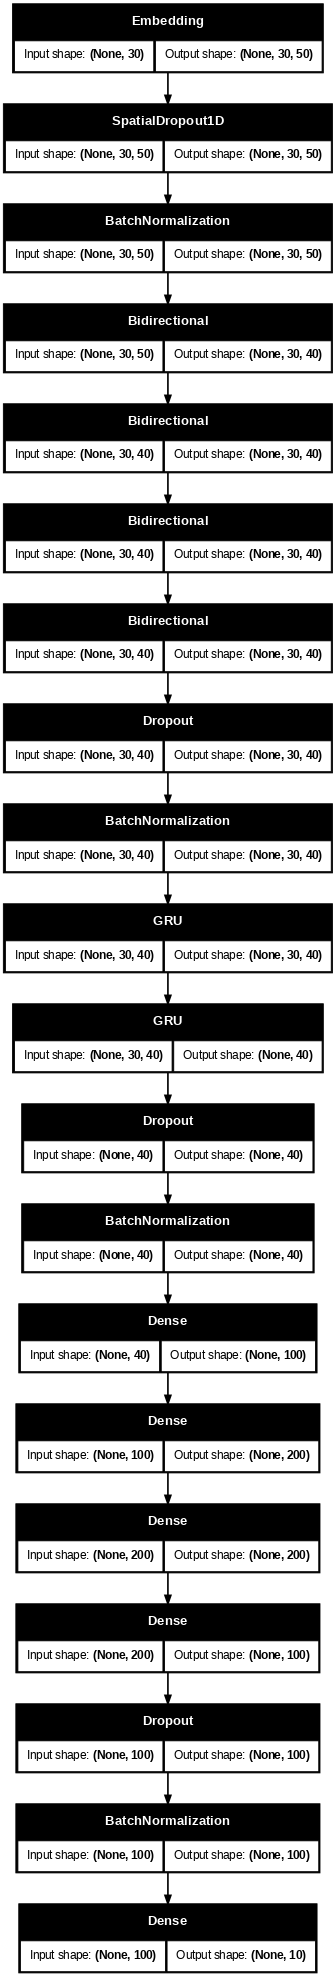

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - accuracy: 0.8924 - loss: 0.7196 - val_accuracy: 0.4420 - val_loss: 3.0571
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8686 - loss: 0.4679 - val_accuracy: 0.4638 - val_loss: 3.1589
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9486 - loss: 0.2126 - val_accuracy: 0.4710 - val_loss: 3.4791
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9516 - loss: 0.1989 - val_accuracy: 0.4348 - val_loss: 3.7818
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9427 - loss: 0.2340 - val_accuracy: 0.4783 - val_loss: 3.2355
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9714 - loss: 0.1047 - val_accuracy: 0.4348 - val_loss: 3.5387
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9549 - loss: 0.1849 - val_accuracy: 0.4928 - val_loss: 3.0857
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9742 - loss: 0.0866 - val_accuracy: 0.4348 -

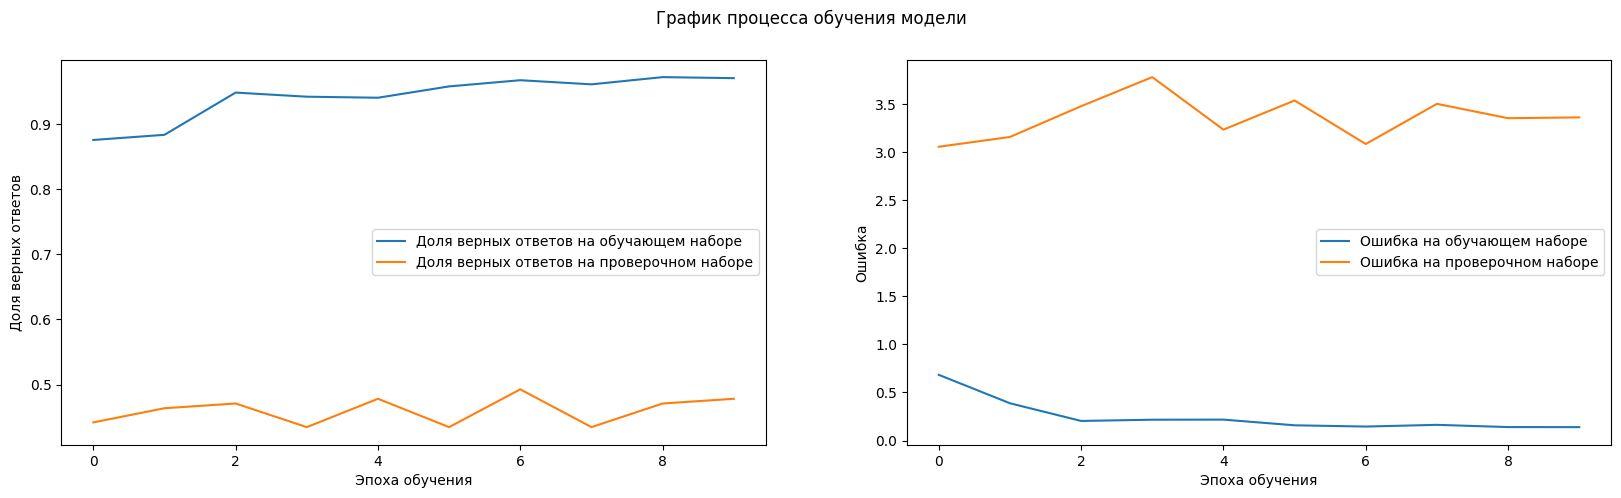

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 351ms/step


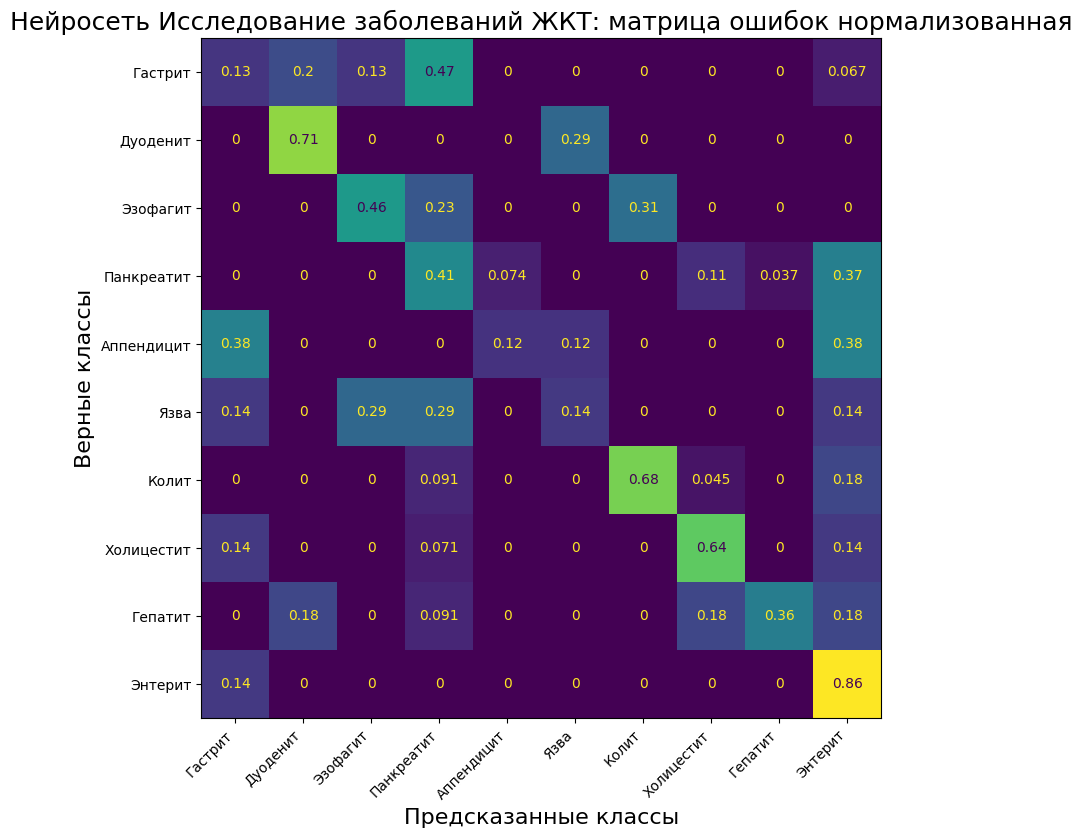

----------------------------------------------------------------------------------------------------
Нейросеть: Исследование заболеваний ЖКТ
Класс: Гастрит               47% сеть отнесла к классу Панкреатит           - НЕВЕРНО :-(
Класс: Дуоденит              71% сеть отнесла к классу Дуоденит             - ВЕРНО :-)
Класс: Эзофагит              46% сеть отнесла к классу Эзофагит             - ВЕРНО :-)
Класс: Панкреатит            41% сеть отнесла к классу Панкреатит           - ВЕРНО :-)
Класс: Аппендицит            38% сеть отнесла к классу Гастрит              - НЕВЕРНО :-(
Класс: Язва                  29% сеть отнесла к классу Эзофагит             - НЕВЕРНО :-(
Класс: Колит                 68% сеть отнесла к классу Колит                - ВЕРНО :-)
Класс: Холицестит            64% сеть отнесла к классу Холицестит           - ВЕРНО :-)
Класс: Гепатит               36% сеть отнесла к классу Гепатит              - ВЕРНО :-)
Класс: Энтерит               86% сеть отнесла к классу Энтери

In [ ]:
model_LSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

with timex() as t:
    history = model_LSTM.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

compile_train_eval_model(model_LSTM,
                         x_train, y_train,
                         x_test, y_test,
                         optimizer='rmsprop',
                         epochs=10,
                         batch_size=32,
                         class_labels=CLASS_LIST,
                         title='Исследование заболеваний ЖКТ')